In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

try:
    data = np.loadtxt('aestraining.csv', delimiter=',')
    labels = np.loadtxt('aeslabel.csv')
except:
    try:
        data = np.loadtxt('aestraining.csv')
        labels = np.loadtxt('aeslabel.csv')
    except Exception as e:
        print(f"Error loading files: {e}")
        raise

df = pd.DataFrame({
    'Feature1': data[:, 0],
    'Feature2': data[:, 1],
    'Feature3': data[:, 2],
    'Label': labels
})

In [3]:
def get_distribution_stats(data_window):
    return {
        'mean': np.mean(data_window, axis=0),
        'std': np.std(data_window, axis=0),
        'median': np.median(data_window, axis=0),
        'skewness': [np.mean((data_window[:, i] - np.mean(data_window[:, i]))**3 / 
                    (np.std(data_window[:, i])**3 + 1e-9)) for i in range(data_window.shape[1])]
    }


window_size = 100 
step_size = 50 
threshold = 1.5 

windows = []
drift_scores = []
feature_cols = ['Feature1', 'Feature2', 'Feature3']

for i in range(0, len(df)-window_size+1, step_size):
    current_window = df[feature_cols].iloc[i:i+window_size].values
    stats = get_distribution_stats(current_window)
    windows.append(stats)

    if i == 0:
        base_stats = stats
        drift_score = 0
    else:
        mean_diff = np.sum(np.abs(stats['mean'] - base_stats['mean']))
        std_diff = np.sum(np.abs(stats['std'] - base_stats['std'])) * 0.5
        drift_score = mean_diff + std_diff
        
    drift_scores.append(drift_score)


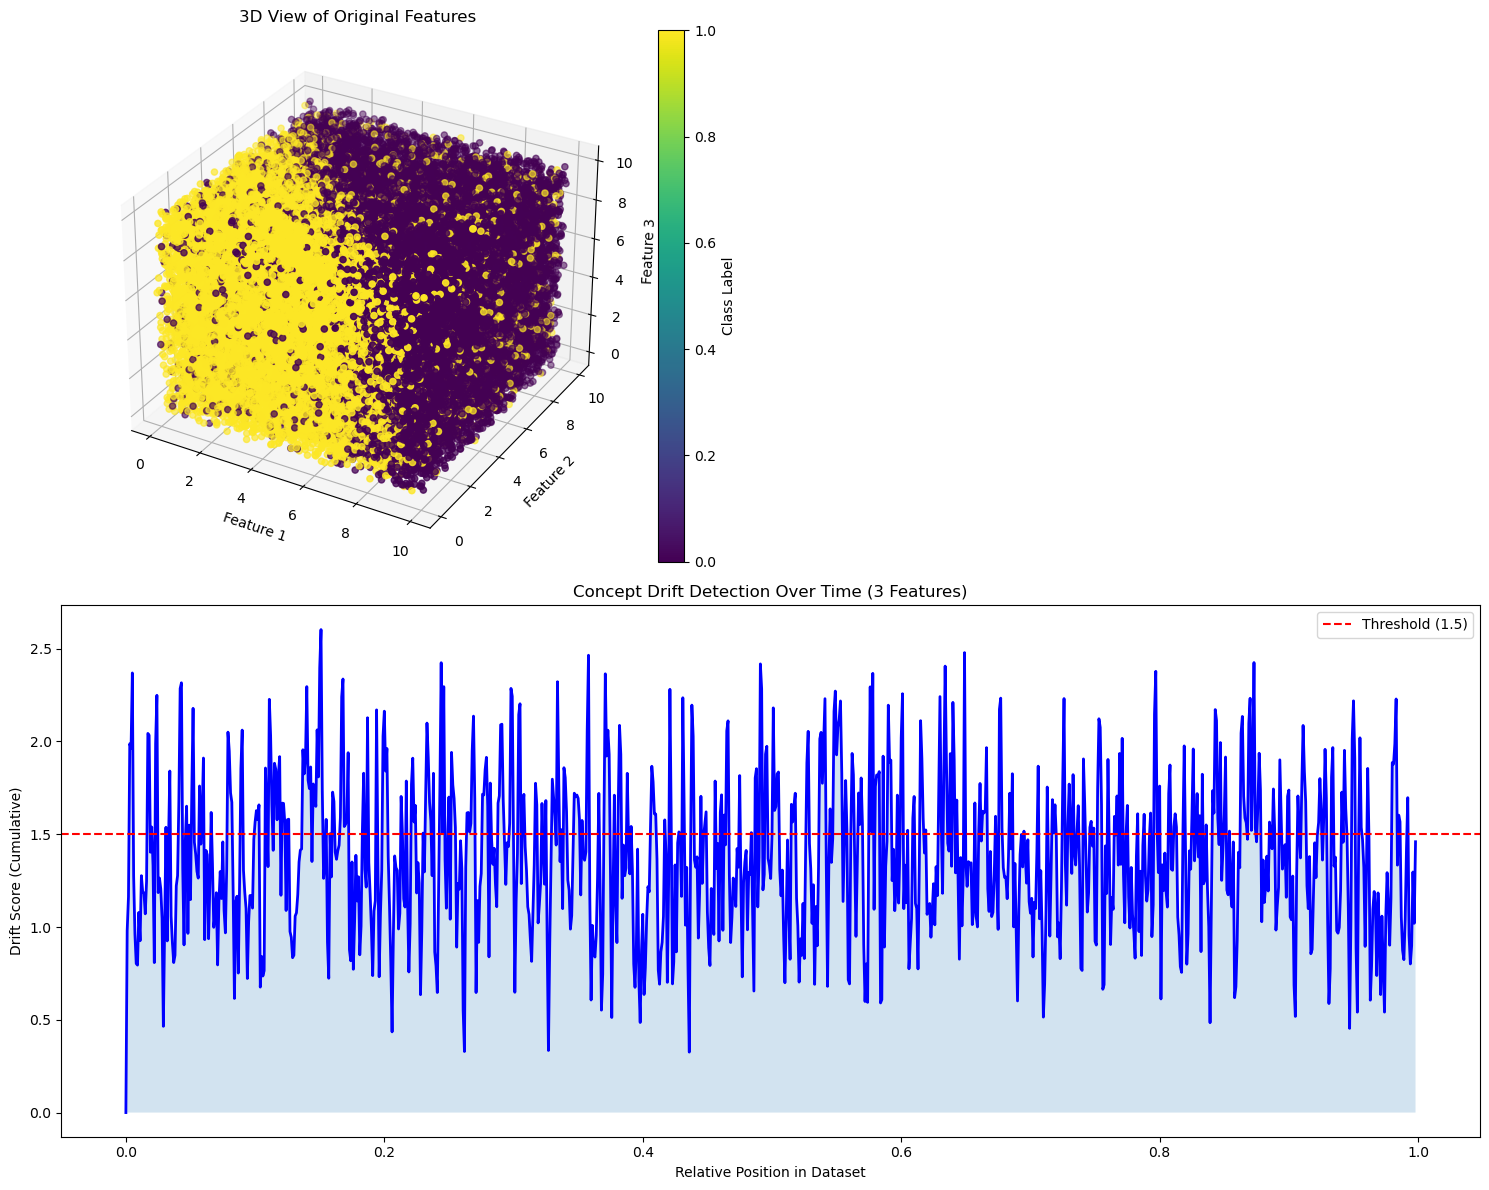

In [6]:
plt.figure(figsize=(15, 12))

ax1 = plt.subplot(221, projection='3d')
scatter1 = ax1.scatter(df['Feature1'], df['Feature2'], df['Feature3'], 
                      c=df['Label'], cmap='viridis')
ax1.set_title('3D View of Original Features')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
plt.colorbar(scatter1, ax=ax1, label='Class Label')

plt.subplot(212)
window_indices = np.arange(len(drift_scores)) * step_size / len(df)
plt.plot(window_indices, drift_scores, 'b-', linewidth=2)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
plt.fill_between(window_indices, drift_scores, alpha=0.2)
plt.title('Concept Drift Detection Over Time (3 Features)')
plt.xlabel('Relative Position in Dataset')
plt.ylabel('Drift Score (Cumulative)')
plt.legend()

plt.tight_layout()
plt.show()